## Forecasting Sales of given sub categories of sales data of a store

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
from numpy import log
from pandas import Series
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\New\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load data

In [2]:
dataset = pd.read_csv(r"C:\Users\This Pc\Desktop\csv\TSFA\Super_store.csv", encoding="windows-1252")

In [3]:
dataset.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


### We can predict sales and profit by using
### Order Date
### Sub-category wise
### Region wise

In [4]:
# Required - YYYY-MM-DD
dataset['Order Date'] = pd.to_datetime(dataset['Order Date'])
dataset

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,2014-06-09,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,2014-06-09,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,9963,CA-2015-168088,2015-03-19,3/22/2015,First Class,CM-12655,Corinna Mitchell,Home Office,United States,Houston,...,77041,Central,FUR-BO-10004218,Furniture,Bookcases,Bush Heritage Pine Collection 5-Shelf Bookcase...,383.4656,4,0.32,-67.6704
2117,9965,CA-2016-146374,2016-12-05,12/10/2016,Second Class,HE-14800,Harold Engle,Corporate,United States,Newark,...,19711,East,FUR-FU-10002671,Furniture,Furnishings,Electrix 20W Halogen Replacement Bulb for Zoom...,13.4000,1,0.00,6.4320
2118,9981,US-2015-151435,2015-09-06,9/9/2015,Second Class,SW-20455,Shaun Weien,Consumer,United States,Lafayette,...,70506,South,FUR-TA-10001039,Furniture,Tables,KI Adjustable-Height Table,85.9800,1,0.00,22.3548
2119,9990,CA-2014-110422,2014-01-21,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         2121 non-null   int64         
 1   Order ID       2121 non-null   object        
 2   Order Date     2121 non-null   datetime64[ns]
 3   Ship Date      2121 non-null   object        
 4   Ship Mode      2121 non-null   object        
 5   Customer ID    2121 non-null   object        
 6   Customer Name  2121 non-null   object        
 7   Segment        2121 non-null   object        
 8   Country        2121 non-null   object        
 9   City           2121 non-null   object        
 10  State          2121 non-null   object        
 11  Postal Code    2121 non-null   int64         
 12  Region         2121 non-null   object        
 13  Product ID     2121 non-null   object        
 14  Category       2121 non-null   object        
 15  Sub-Category   2121 n

In [6]:
dataset.isnull().any()

Row ID           False
Order ID         False
Order Date       False
Ship Date        False
Ship Mode        False
Customer ID      False
Customer Name    False
Segment          False
Country          False
City             False
State            False
Postal Code      False
Region           False
Product ID       False
Category         False
Sub-Category     False
Product Name     False
Sales            False
Quantity         False
Discount         False
Profit           False
dtype: bool

In [7]:
dataset['Category'].unique()

array(['Furniture'], dtype=object)

In [8]:
dataset['Sub-Category'].unique()

array(['Bookcases', 'Chairs', 'Tables', 'Furnishings'], dtype=object)

In [9]:
dataset['Sub-Category'].value_counts()

Furnishings    957
Chairs         617
Tables         319
Bookcases      228
Name: Sub-Category, dtype: int64

In [10]:
Furniture=dataset.loc[dataset['Category']=='Furniture']

In [11]:
Furnishings = dataset.loc[dataset['Sub-Category'] == 'Furnishings']

## Explore data sub category wise

### Furnishings

In [12]:
Furnishings.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
3,6,CA-2014-115812,2014-06-09,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.86,7,0.0,14.1694
8,30,US-2015-150630,2015-09-17,9/21/2015,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-FU-10004848,Furniture,Furnishings,"Howard Miller 13-3/4"" Diameter Brushed Chrome ...",124.20,3,0.2,15.5250
9,37,CA-2016-117590,2016-12-08,12/10/2016,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,FUR-FU-10003664,Furniture,Furnishings,"Electrix Architect's Clamp-On Swing Arm Lamp, ...",190.92,5,0.6,-147.9630
12,52,CA-2015-115742,2015-04-18,4/22/2015,Standard Class,DP-13000,Darren Powers,Consumer,United States,New Albany,...,47150,Central,FUR-FU-10001706,Furniture,Furnishings,Longer-Life Soft White Bulbs,6.16,2,0.0,2.9568
15,66,CA-2015-135545,2015-11-24,11/30/2015,Standard Class,KM-16720,Kunst Miller,Consumer,United States,Los Angeles,...,90004,West,FUR-FU-10000397,Furniture,Furnishings,Luxo Economy Swing Arm Lamp,79.76,4,0.0,22.3328


In [13]:
Furnishings1=Furnishings.copy()

In [14]:
Furnishings1['Order Date'].min(), Furnishings1['Order Date'].max()

(Timestamp('2014-01-07 00:00:00'), Timestamp('2017-12-29 00:00:00'))

In [15]:
Furnishings.shape

(957, 21)

In [16]:
Furnishings1.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
3,6,CA-2014-115812,2014-06-09,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.86,7,0.0,14.1694
8,30,US-2015-150630,2015-09-17,9/21/2015,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-FU-10004848,Furniture,Furnishings,"Howard Miller 13-3/4"" Diameter Brushed Chrome ...",124.20,3,0.2,15.5250
9,37,CA-2016-117590,2016-12-08,12/10/2016,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,FUR-FU-10003664,Furniture,Furnishings,"Electrix Architect's Clamp-On Swing Arm Lamp, ...",190.92,5,0.6,-147.9630
12,52,CA-2015-115742,2015-04-18,4/22/2015,Standard Class,DP-13000,Darren Powers,Consumer,United States,New Albany,...,47150,Central,FUR-FU-10001706,Furniture,Furnishings,Longer-Life Soft White Bulbs,6.16,2,0.0,2.9568
15,66,CA-2015-135545,2015-11-24,11/30/2015,Standard Class,KM-16720,Kunst Miller,Consumer,United States,Los Angeles,...,90004,West,FUR-FU-10000397,Furniture,Furnishings,Luxo Economy Swing Arm Lamp,79.76,4,0.0,22.3328


In [17]:
Furnishings1 = Furnishings1[['Order Date','Sales']]
Furnishings1.head()

,Order Date,Sales
3,2014-06-09,48.86
8,2015-09-17,124.20
9,2016-12-08,190.92
12,2015-04-18,6.16
15,2015-11-24,79.76


In [18]:
Furnishings1.shape

(957, 2)

In [19]:
Furnishings1 = Furnishings1.sort_values('Order Date')
Furnishings1 = Furnishings1.groupby('Order Date')['Sales'].sum().reset_index()
Furnishings1.head()

,Order Date,Sales
0,2014-01-07,76.728
1,2014-01-10,51.940
2,2014-01-11,9.940
3,2014-01-16,127.104
4,2014-01-20,345.570


## Indexing by order date

In [20]:
Furnishings1 = Furnishings1.set_index('Order Date')
Furnishings1.head()

,Sales
Order Date,
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-16,127.104
2014-01-20,345.570


In [21]:
Furnishings1.index

DatetimeIndex(['2014-01-07', '2014-01-10', '2014-01-11', '2014-01-16',
               '2014-01-20', '2014-01-21', '2014-01-26', '2014-02-08',
               '2014-02-11', '2014-02-18',
               ...
               '2017-12-16', '2017-12-17', '2017-12-18', '2017-12-19',
               '2017-12-21', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Order Date', length=599, freq=None)

In [22]:
Furnishings1.shape

(599, 1)

### Fill missed dates by monthly format

In [23]:
monthly_fur = Furnishings1['Sales'].resample('MS').mean()

In [24]:
monthly_fur.head()

Order Date
2014-01-01    101.681429
2014-02-01     98.245000
2014-03-01     68.589714
2014-04-01     98.404600
2014-05-01    111.452286
Freq: MS, Name: Sales, dtype: float64

In [25]:
monthly_fur.shape

(48,)

In [26]:
monthly_fur['2014']

Order Date
2014-01-01    101.681429
2014-02-01     98.245000
2014-03-01     68.589714
2014-04-01     98.404600
2014-05-01    111.452286
2014-06-01     54.093750
2014-07-01    112.827750
2014-08-01     99.775800
2014-09-01    148.047800
2014-10-01     69.090222
2014-11-01    137.986778
2014-12-01    148.391714
Freq: MS, Name: Sales, dtype: float64

In [27]:
monthly_fur['2015']

Order Date
2015-01-01    254.022800
2015-02-01    103.052000
2015-03-01    143.595800
2015-04-01    299.318800
2015-05-01    127.682833
2015-06-01    178.351857
2015-07-01    132.555636
2015-08-01     72.750182
2015-09-01    137.476500
2015-10-01     77.095000
2015-11-01    186.835684
2015-12-01    140.589000
Freq: MS, Name: Sales, dtype: float64

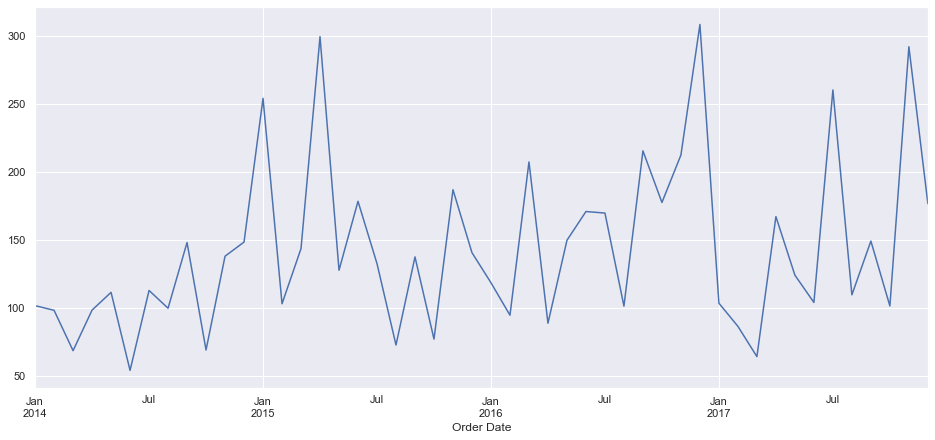

In [28]:
monthly_fur.plot(figsize = (16, 7))
plt.show()

### Decomposition method required to check Trend Seasonality and Noise 

<Figure size 1080x504 with 0 Axes>

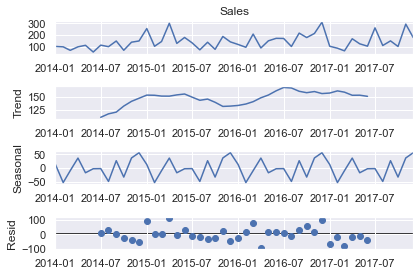

In [29]:
decomposition = seasonal_decompose(monthly_fur, model='additive', 
                                   period=12)
decomposition.plot()
plt.show()

### Use Durbin watson test to detect autocorrelation

In [30]:
sm.stats.durbin_watson(monthly_fur)

0.3088162986591814

In [31]:
from statsmodels.tsa.stattools import adfuller

### Use Augmented dickey fuller test to check whether data is staionary or not

In [32]:
def adf_check(timeseries):
    result = adfuller(timeseries)
    print("Augmented Dickey Fuller Test : To find data is stationary or non-stationary")
    labels = ['ADF Stats Test','P-Values', '#Lags','No. of Observation']
    
    for i , j in zip(result, labels):
        print(j + " = " + str(i))
    
    if result[1] <=0.05:
        print("Strong evidence against null hypothesis and my time series is Stationary")
    else:
        print("Weak evidence against null hypothesis and my time series is Non-Stationary")    

In [33]:
adf_check(monthly_fur)

Augmented Dickey Fuller Test : To find data is stationary or non-stationary
ADF Stats Test = -6.582724497269475
P-Values = 7.444389290815513e-09
#Lags = 0
No. of Observation = 47
Strong evidence against null hypothesis and my time series is Stationary


### Auto approach

In [34]:
import itertools
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


### Use SARIMAX model

In [35]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(monthly_fur, order = param,
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False)
            results_fur = model.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results_fur.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:610.4523391155499


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1492.5716501207105
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:412.47012489596443
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:265.0805373060343
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:427.850528951821
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1166.4457379996074
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:277.90619262177574
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:268.51925989458965
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:575.5457157153994


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2631.408973981959
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:403.70962365731583
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:256.728394591261
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:429.83784347005474


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2506.9749543264147
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:279.89143030161233
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:260.03041149027035
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:544.8544820387906


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1331.9072506976456
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:424.94652213291715
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:270.52466970828107
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:423.1864486598583


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1207.007888535245
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:282.9674944744002
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:271.47588099494493
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:507.7145149054754


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2163.5634720012795
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:395.1578650441822
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:245.5074828317606
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:399.7525970635495


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2336.4083976507636
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:271.6528062772164
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:249.36921264015123
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:554.2157561479629


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1725.1453848541933
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:414.45490975584534
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:267.0368061377406
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:415.5637131310541


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1167.8431056973309
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:268.85514515917055
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:270.5003950305288
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:518.2151984657917


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2495.671567512527
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:401.4547901661359
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:257.12839025956714
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:403.66434028914676
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1503.0009333788194


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:270.085343918696
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:261.7379658527608
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:528.736580777553
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1253.8707405232644


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:413.55056570894357
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:263.82251472617276
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:399.01458981595385


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1418.1433030213345
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:264.31736964914035
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:264.30023555648086
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:509.5565659721754


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1932.017253658777
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:395.93582521648284
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:247.27279029966073
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:389.90725783394885


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2237.9146107092465
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:262.48884991431726
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:251.11291177389018


### check for less AIC value to get good order of trend and seasonality

####  we get ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:245.5074828317705

In [36]:
model = sm.tsa.statespace.SARIMAX(monthly_fur, order = (0,1,1),
                               seasonal_order = (0,1,1,12),
                               enforce_stationarity = False,
                               enforce_invertibility = False)

results_fur = model.fit()
print(results_fur.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   2145.077     -0.000      1.000   -4205.274    4203.274
ma.S.L12      -1.0000   2145.090     -0.000      1.000   -4205.300    4203.300
sigma2      3416.4424      0.439   7779.534      0.000    3415.582    3417.303


In [37]:
len(monthly_fur)

48

### Validating Furnishing sales

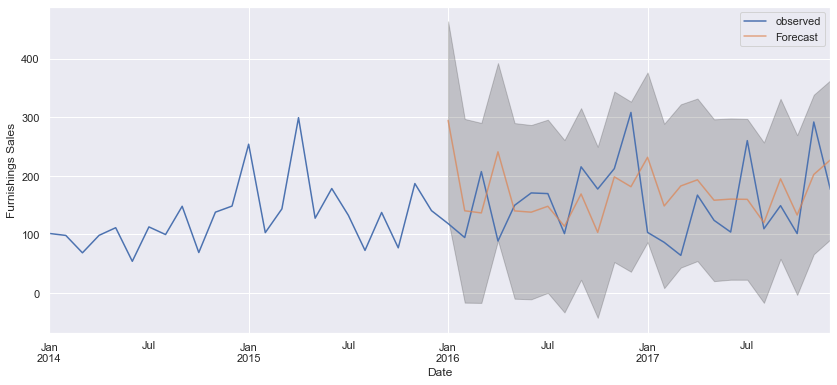

In [38]:
pred = results_fur.get_prediction(start = pd.to_datetime('2016-01-01'), dynamic = False)
pred_ci = pred.conf_int()

ax = monthly_fur['2014':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'Forecast', alpha = .7, figsize = (14, 6))

ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
               color = 'k',
               alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('Furnishings Sales')
plt.legend()
plt.show()

In [39]:
monthly_fur_forecasted = pred.predicted_mean
monthly_fur_truth = monthly_fur['2017-01-01':]

mse = ((monthly_fur_forecasted -monthly_fur_truth)**2).mean()

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 5268.71


In [40]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 72.59


### Predicting future sales of furnishings

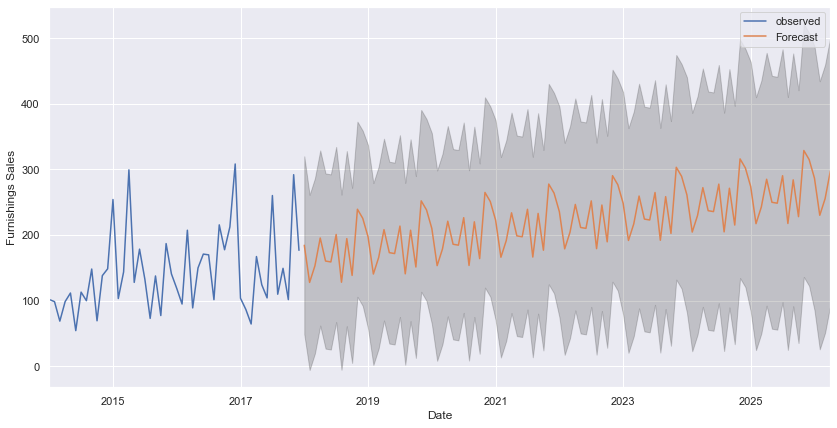

In [41]:
pred_uc = results_fur.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()

ax = monthly_fur.plot(label = 'observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax = ax, label ='Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],
               color = 'k',
               alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('Furnishings Sales')
plt.legend()
plt.show()

## CHAIRS 

In [42]:
Chairs = dataset.loc[dataset['Sub-Category'] == 'Chairs']

In [43]:
Chairs['Order Date'].min(), Chairs['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-29 00:00:00'))

In [44]:
Chairs1=Chairs.copy()

In [45]:
Chairs1.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.940,3,0.0,219.5820
5,24,US-2017-156909,2017-07-16,7/18/2017,Second Class,SF-20065,Sandra Flanagan,Consumer,United States,Philadelphia,...,19140,East,FUR-CH-10002774,Furniture,Chairs,"Global Deluxe Stacking Chair, Gray",71.372,2,0.3,-1.0196
11,40,CA-2015-117415,2015-12-27,12/31/2015,Standard Class,SN-20710,Steve Nguyen,Home Office,United States,Houston,...,77041,Central,FUR-CH-10004218,Furniture,Chairs,"Global Fabric Manager's Chair, Dark Gray",212.058,3,0.3,-15.1470
13,53,CA-2015-115742,2015-04-18,4/22/2015,Standard Class,DP-13000,Darren Powers,Consumer,United States,New Albany,...,47150,Central,FUR-CH-10003061,Furniture,Chairs,"Global Leather Task Chair, Black",89.990,1,0.0,17.0981
14,58,CA-2016-111682,2016-06-17,6/18/2016,First Class,TB-21055,Ted Butterfield,Consumer,United States,Troy,...,12180,East,FUR-CH-10003968,Furniture,Chairs,Novimex Turbo Task Chair,319.410,5,0.1,7.0980


In [46]:
Chairs1 = Chairs1[['Order Date','Sales']]
Chairs1.head()

,Order Date,Sales
1,2016-11-08,731.940
5,2017-07-16,71.372
11,2015-12-27,212.058
13,2015-04-18,89.990
14,2016-06-17,319.410


In [47]:
Chairs.shape

(617, 21)

In [48]:
Chairs1.shape

(617, 2)

In [49]:
Chairs1 = Chairs1.sort_values('Order Date')
Chairs1 = Chairs1.groupby('Order Date')['Sales'].sum().reset_index()
Chairs1.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-13,545.940
2,2014-01-20,1067.940
3,2014-02-11,60.890
4,2014-02-12,129.568


### Indexing 

In [50]:
Chairs1 = Chairs1.set_index('Order Date')
Chairs1.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-13,545.940
2014-01-20,1067.940
2014-02-11,60.890
2014-02-12,129.568


### Creating data in monthly format

In [51]:
monthly_chairs= Chairs1['Sales'].resample('MS').mean()

In [52]:
monthly_chairs.head(10)

Order Date
2014-01-01    1395.900000
2014-02-01      95.229000
2014-03-01     714.142750
2014-04-01     642.133200
2014-05-01     459.388625
2014-06-01    1076.000167
2014-07-01     636.494000
2014-08-01     863.414000
2014-09-01    1259.016818
2014-10-01     720.733889
Freq: MS, Name: Sales, dtype: float64

In [53]:
monthly_chairs['2014']

Order Date
2014-01-01    1395.900000
2014-02-01      95.229000
2014-03-01     714.142750
2014-04-01     642.133200
2014-05-01     459.388625
2014-06-01    1076.000167
2014-07-01     636.494000
2014-08-01     863.414000
2014-09-01    1259.016818
2014-10-01     720.733889
2014-11-01     606.879500
2014-12-01    1148.998267
Freq: MS, Name: Sales, dtype: float64

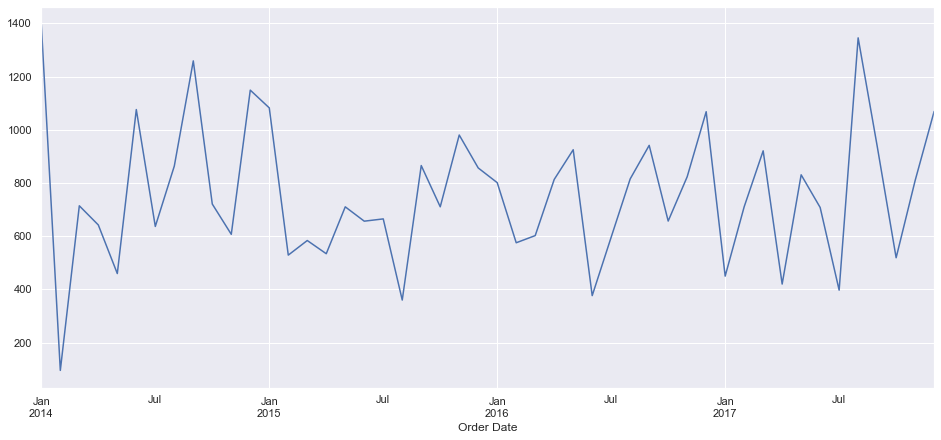

In [54]:
monthly_chairs.plot(figsize = (16, 7))
plt.show()

### Decomposition method required

<Figure size 1080x504 with 0 Axes>

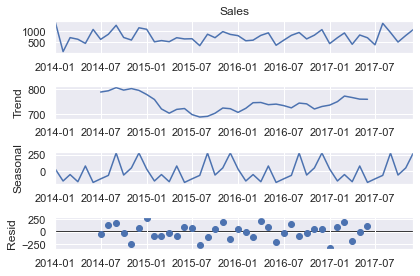

In [55]:
decomposition = seasonal_decompose(monthly_chairs, model='additive', 
                                   period=12)
decomposition.plot()
plt.show()

### Durbin watson test

In [56]:
sm.stats.durbin_watson(monthly_chairs)

0.2414550110105628

### Augmented dickey fuller test

In [57]:
adf_check(monthly_chairs)

Augmented Dickey Fuller Test : To find data is stationary or non-stationary
ADF Stats Test = -6.3524919182628015
P-Values = 2.59029475390211e-08
#Lags = 1
No. of Observation = 46
Strong evidence against null hypothesis and my time series is Stationary


### Model building

In [58]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(monthly_chairs, order = param,
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False)
            results_chairs = model.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results_chairs.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:761.6317440106498
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1769.1168587090363
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:492.80061035857483


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:321.7633025600051
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:506.73501866513794


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1080.4340042193726
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:336.00958562724
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:323.4403697814414
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:711.7294144433822
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2765.7622786773727
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:477.64068042810794


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:304.4058653924112
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:507.0461614084188


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2727.4559053629805
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:334.1782534176378
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:305.9984023984941
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:672.1932776653902


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1569.270702693353
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:507.36952551180707
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:329.55709607162146
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:506.8811712886196


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1582.5937987486948
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:343.9485400436612
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:331.5219409111928
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:629.5167651023985
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2149.86123911115


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:468.29155424039345
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:299.9253787970596
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:483.6936495232561


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2573.8763485871045
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:326.8330166937291
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:301.92537750217076
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:696.1529129241839


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1472.7629791610775
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:493.17223010306805
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:321.5862639581749
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:493.87562193846077
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1436.5248208861071
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:321.8160378846392
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:323.1798810729868
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:647.6418573757301
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2670.6998471104266


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:479.42194193697514
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:306.510070181672
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:483.9716562764943
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1523.159603331971


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:320.31521911887484
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:307.650269798613
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:662.7097099458582
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1500.6286696793854
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:498.95844444308545
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:325.36188130510374
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:487.0116464166325
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1436.7646269890608
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:325.38954037998445
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:327.17625827894346
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:631.0940107564879


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2619.2648850673495
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:469.6345396516354
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:300.8722799092764
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:470.7937128615252


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2656.653884933715
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:313.514518969731
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:301.59298687561636


### Best AIC value ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:299.9253787970596

In [59]:
model = sm.tsa.statespace.SARIMAX(monthly_chairs, order = (0,1,1),
                               seasonal_order = (0,1,1,12),
                               enforce_stationarity = False,
                               enforce_invertibility = False)

results_chairs = model.fit()
print(results_chairs.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      0.363     -2.751      0.006      -1.712      -0.288
ma.S.L12      -0.1232      0.184     -0.669      0.504      -0.484       0.238
sigma2      6.659e+04   5.46e-06   1.22e+10      0.000    6.66e+04    6.66e+04


In [60]:
len(monthly_chairs)

48

### Validation  plot

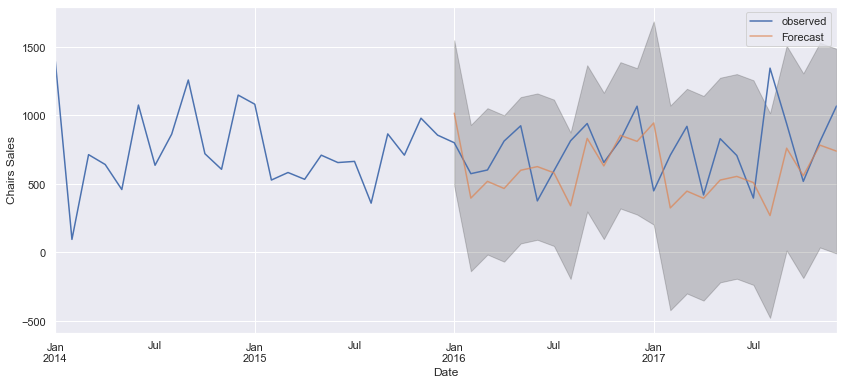

In [61]:
pred= results_chairs.get_prediction(start = pd.to_datetime('2016-01-01'), dynamic = True)
pred_ci = pred.conf_int()

ax = monthly_chairs['2014':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'Forecast', alpha = .7, figsize = (14, 6))

ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
               color = 'k',
               alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('Chairs Sales')
plt.legend()
plt.show()

In [62]:
monthly_chairs_forecasted = pred.predicted_mean
monthly_chairs_truth = monthly_chairs['2017-01-01':]

mse= ((monthly_chairs_forecasted -monthly_chairs_truth)**2).mean()

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 170563.72


In [63]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 412.99


### Future prediction of chairs by sales

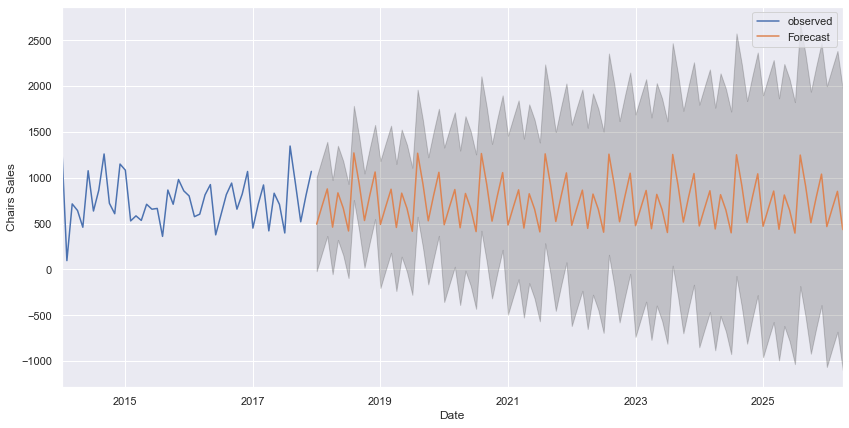

In [64]:
pred_uc = results_chairs.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()

ax = monthly_chairs.plot(label = 'observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax = ax, label ='Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],
               color = 'k',
               alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('Chairs Sales')
plt.legend()
plt.show()

## Bookcases

In [65]:
Bookcases = dataset.loc[dataset['Sub-Category'] == 'Bookcases']

In [66]:
Bookcases['Order Date'].min(), Bookcases['Order Date'].max()

(Timestamp('2014-01-13 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [67]:
Bookcases1=Bookcases.copy()

In [68]:
Bookcases.shape

(228, 21)

In [69]:
Bookcases1 = Bookcases1[['Order Date','Sales']]
Bookcases1.head()

,Order Date,Sales
0,2016-11-08,261.9600
7,2015-09-17,3083.4300
10,2015-12-27,532.3992
40,2015-10-12,899.1360
41,2015-10-12,626.3520


In [70]:
Bookcases1.shape

(228, 2)

In [71]:
Bookcases1 = Bookcases1.sort_values('Order Date')
Bookcases1 = Bookcases1.groupby('Order Date')['Sales'].sum().reset_index()
Bookcases1.head()

,Order Date,Sales
0,2014-01-13,333.999
1,2014-01-14,61.960
2,2014-01-19,181.470
3,2014-01-26,141.960
4,2014-01-31,290.666


### Indexing

In [72]:
Bookcases1 = Bookcases1.set_index('Order Date')
Bookcases1.head()

,Sales
Order Date,
2014-01-13,333.999
2014-01-14,61.960
2014-01-19,181.470
2014-01-26,141.960
2014-01-31,290.666


In [73]:
monthly_book= Bookcases1['Sales'].resample('MS').mean()

In [74]:
monthly_book.head()

Order Date
2014-01-01    202.011000
2014-02-01           NaN
2014-03-01    568.815333
2014-04-01    308.499000
2014-05-01    320.315500
Freq: MS, Name: Sales, dtype: float64

In [75]:
monthly_book.isnull().sum()
# 2014-02-01     True
# 2016-05-01     True

2

### Impute missing values by median

In [76]:
monthly_book = monthly_book.fillna(monthly_book.median())

In [77]:
monthly_book['2014']

Order Date
2014-01-01     202.011000
2014-02-01     501.074300
2014-03-01     568.815333
2014-04-01     308.499000
2014-05-01     320.315500
2014-06-01     253.191200
2014-07-01     743.836500
2014-08-01     397.138000
2014-09-01     798.156600
2014-10-01     616.998000
2014-11-01     807.079300
2014-12-01    1018.114167
Freq: MS, Name: Sales, dtype: float64

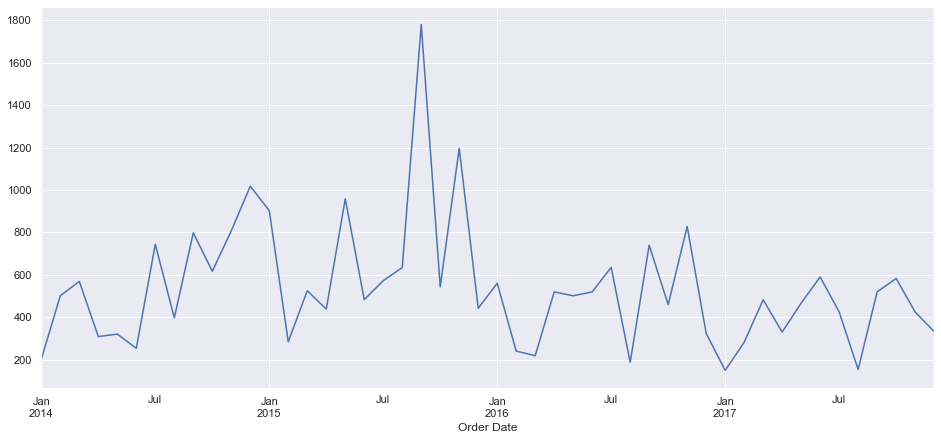

In [78]:
monthly_book.plot(figsize = (16, 7))
plt.show()

### Decomposition required

<Figure size 1080x504 with 0 Axes>

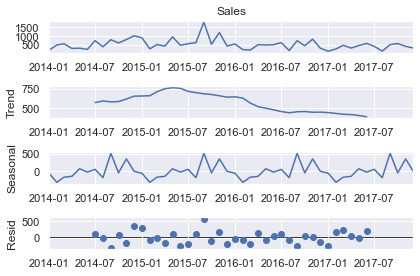

In [79]:
decomposition = seasonal_decompose(monthly_book,model='additive', 
                                   period=12)
decomposition.plot()
plt.show()

### Autocorrelation test

In [80]:
sm.stats.durbin_watson(monthly_book)

0.40299183015628937

### Check data is staionary or not

In [81]:
adf_check(monthly_book)

Augmented Dickey Fuller Test : To find data is stationary or non-stationary
ADF Stats Test = -3.23804942848297
P-Values = 0.01788520233243916
#Lags = 1
No. of Observation = 46
Strong evidence against null hypothesis and my time series is Stationary


### Modeling

In [82]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(monthly_book, order = param,
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False)
            results_book = model.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results_book.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:739.3359981597563


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1114.7265910194692
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:513.0421054702749
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:329.4456399034896
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:525.9624302375344


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1635.9364816103748
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:344.82351536727873
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:331.21760339380114
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:708.0198370717334
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2674.311675110468
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:500.3684226056823


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:316.30689844933744
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:527.2463217197702


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2584.3074839299416
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:345.6006836191193
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:318.1293459984105
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:682.3628455787294
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1314.1069705319942


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:516.7975220610609
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:319.03523909473057
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:522.3309303956624


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1298.8619408869342
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:340.21166570003555
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:320.9392681800896
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:645.6665191132377
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2292.703543658775
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:486.2973311073746
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:296.7875222884777
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:506.000834520859


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2212.93705529983
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:325.6965912771496
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:297.3526433574585
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:693.8053720083107


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1462.4617859044608
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:514.5252198424863
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:327.84569249029437
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:508.52840645199285


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:951.3727007907878
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:331.70210604835285
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:329.78656953259923
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:661.0478461989602


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2595.8501355908766
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:500.0555389067015
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:313.51170260473015
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:502.7015796994906


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2670.957618989356
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:331.01830507017587
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:315.5048419038568
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:662.9945246543992


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1251.3278842391337
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:508.94919042866167
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:315.08590380248523
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:493.39112986501647


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1274.0155497617377
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:319.69228057217765
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:317.07001866573336
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:647.6413098117313


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2043.151328129207
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:488.129832796421
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:298.78794086911535
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:489.3371202289514


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:383.00960604726555
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:314.01309685499336
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:299.34271284402615


### Best AIC value ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:298.78794086735246

In [83]:
model = sm.tsa.statespace.SARIMAX(monthly_book, order = (1,1,1),
                               seasonal_order = (0,1,1,12),
                               enforce_stationarity = False,
                               enforce_invertibility = False)

results_book = model.fit()
print(results_book.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0313      0.330     -0.095      0.924      -0.678       0.616
ma.L1         -0.8176      0.177     -4.609      0.000      -1.165      -0.470
ma.S.L12      -0.7776      0.635     -1.225      0.221      -2.022       0.467
sigma2      5.257e+04   3.66e+04      1.437      0.151   -1.92e+04    1.24e+05


In [84]:
len(monthly_book)

48

### Validation

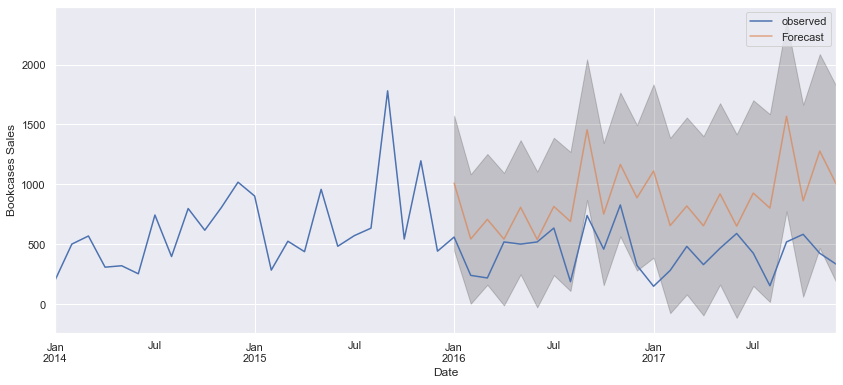

In [85]:
pred= results_book.get_prediction(start = pd.to_datetime('2016-01-01'), dynamic = True)
pred_ci = pred.conf_int()

ax = monthly_book['2014':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'Forecast', alpha = .7, figsize = (14, 6))

ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
               color = 'k',
               alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('Bookcases Sales')
plt.legend()
plt.show()

In [86]:
monthly_book_forecasted = pred.predicted_mean
monthly_book_truth = monthly_book['2017-01-01':]

mse= ((monthly_book_forecasted -monthly_book_truth)**2).mean()

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 376617.14


In [87]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 613.69


### Forecasting

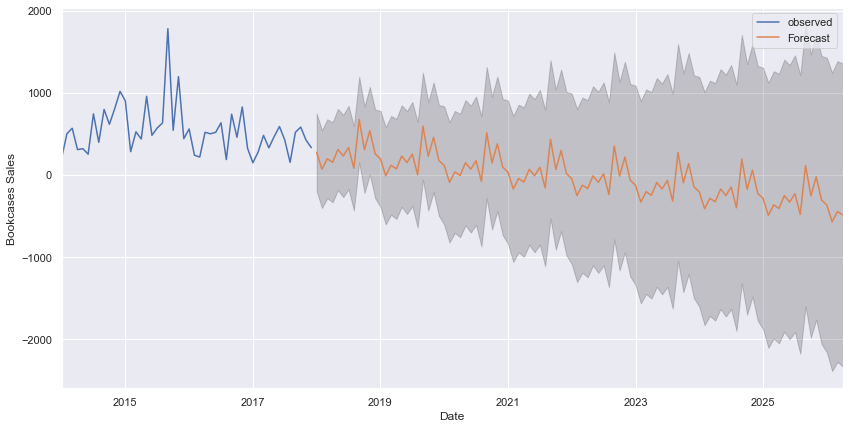

In [88]:
pred_uc = results_book.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()

ax = monthly_book.plot(label = 'observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax = ax, label ='Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],
               color = 'k',
               alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('Bookcases Sales')
plt.legend()
plt.show()

## Tables

In [89]:
Tables = dataset.loc[dataset['Sub-Category'] == 'Tables']

In [90]:
Tables['Order Date'].min(), Tables['Order Date'].max()

(Timestamp('2014-01-27 00:00:00'), Timestamp('2017-12-25 00:00:00'))

In [91]:
Tables1=Tables.copy()

In [92]:
Tables.shape

(319, 21)

In [93]:
Tables1= Tables1[['Order Date','Sales']]
Tables1.head()

,Order Date,Sales
2,2015-10-11,957.5775
4,2014-06-09,1706.1840
6,2015-09-25,1044.6300
26,2015-03-02,787.5300
29,2014-09-20,617.7000


In [94]:
Tables1.shape

(319, 2)

In [95]:
Tables1 = Tables1.sort_values('Order Date')
Tables1 = Tables1.groupby('Order Date')['Sales'].sum().reset_index()
Tables1.head()

,Order Date,Sales
0,2014-01-27,333.000
1,2014-02-11,1256.220
2,2014-03-01,376.509
3,2014-03-03,626.352
4,2014-03-17,3265.230


### Indexing

In [96]:
Tables1 = Tables1.set_index('Order Date')
Tables1.head()

,Sales
Order Date,
2014-01-27,333.000
2014-02-11,1256.220
2014-03-01,376.509
2014-03-03,626.352
2014-03-17,3265.230


In [97]:
monthly_tables= Tables1['Sales'].resample('MS').mean()

In [98]:
monthly_tables.head(10)

Order Date
2014-01-01     333.000000
2014-02-01    1256.220000
2014-03-01    1334.848000
2014-04-01    1147.208667
2014-05-01     454.220250
2014-06-01     793.971571
2014-07-01     344.302667
2014-08-01     587.614100
2014-09-01     922.374000
2014-10-01     915.766400
Freq: MS, Name: Sales, dtype: float64

In [99]:
monthly_tables['2014']

Order Date
2014-01-01     333.000000
2014-02-01    1256.220000
2014-03-01    1334.848000
2014-04-01    1147.208667
2014-05-01     454.220250
2014-06-01     793.971571
2014-07-01     344.302667
2014-08-01     587.614100
2014-09-01     922.374000
2014-10-01     915.766400
2014-11-01     906.968600
2014-12-01    1379.861000
Freq: MS, Name: Sales, dtype: float64

### Checking for trend seasonality residue

<Figure size 1080x504 with 0 Axes>

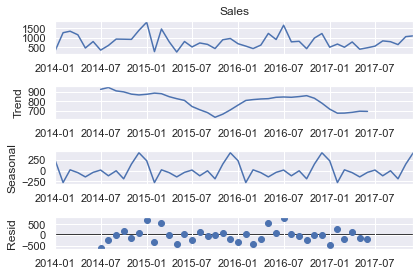

In [100]:
decomposition = seasonal_decompose(monthly_tables, model='additive', 
                                   period=12)
decomposition.plot()
plt.show()

### Autocorr check

In [101]:
sm.stats.durbin_watson(monthly_tables)

0.30004932751563346

### ADF Test

In [102]:
adf_check(monthly_tables)

Augmented Dickey Fuller Test : To find data is stationary or non-stationary
ADF Stats Test = -6.280453103935866
P-Values = 3.807874309352898e-08
#Lags = 0
No. of Observation = 47
Strong evidence against null hypothesis and my time series is Stationary


### Modeling

In [103]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(monthly_tables, order = param,
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False)
            results_tables = model.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results_tables.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:772.9335023203529
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1355.5922146227495
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:536.2544633358926


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:348.4901700650354
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:553.6259261242734


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1281.495033567489
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:366.1335350087346
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:350.48949011113183
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:730.5965355159796
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2570.4240352892884


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:519.6945940922145
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:336.52892697199
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:555.6078772069103
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2488.578445180997


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:367.8922525614216
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:338.5124963262132
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:698.5776326622939
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1400.516067374977
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:539.9052944464289


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:344.4778613854734
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:537.8312806385777


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1338.9055901763963
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:364.5202802049359
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:346.4428615005756
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:664.3767612986129
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2592.8748063636504
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:508.7865260036657
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:323.29734284141085
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:520.5891179383976


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1176.2163597337774
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:355.48860936915133
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:324.9221416349368
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:715.4343770268342


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1342.7402922771612
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:538.1095829219812
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:349.72877676635767
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:530.3282337956125


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1316.8754274486819
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:352.57907593988205
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:351.7284778627402
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:679.2801427363861


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2586.4823069820295
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:520.6283535450327
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:336.40757764793955
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:522.0365406885626


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2345.8393204877475
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:354.2910445228255
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:338.3465238055597
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:688.1880656040881
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1972.0516628783225
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:524.3143500587988
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:339.53997061357984
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:498.80079001586984


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1119.2055937408209
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:342.08940654051855
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:341.53632016047
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:666.1682392030556
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2557.0670314087442


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:510.3214564735535
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:326.1030193474141
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:498.50950852710565


C:\New\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2561.82752319382
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:343.92604270348886
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:326.4925983645869


### Best AIC value we get ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:323.29734284141085

In [104]:
model = sm.tsa.statespace.SARIMAX(monthly_tables, order = (0,1,1),
                               seasonal_order = (0,1,1,12),
                               enforce_stationarity = False,
                               enforce_invertibility = False)

results_tables = model.fit()
print(results_tables.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0043      4.999     -0.201      0.841     -10.802       8.793
ma.S.L12      -1.0982      4.648     -0.236      0.813     -10.208       8.011
sigma2       1.38e+05   1.15e+06      0.120      0.905   -2.12e+06     2.4e+06


In [105]:
len(monthly_tables)

48

### Validation

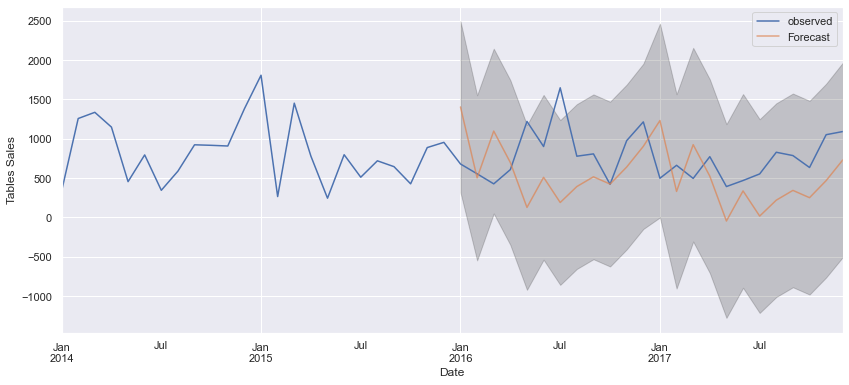

In [106]:
pred= results_tables.get_prediction(start = pd.to_datetime('2016-01-01'), dynamic = True)
pred_ci = pred.conf_int()

ax = monthly_tables['2014':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'Forecast', alpha = .7, figsize = (14, 6))

ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
               color = 'k',
               alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('Tables Sales')
plt.legend()
plt.show()

In [107]:
monthly_tables_forecasted = pred.predicted_mean
monthly_tables_truth = monthly_tables['2017-01-01':]

mse= ((monthly_tables_forecasted -monthly_tables_truth)**2).mean()

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 214342.03


In [108]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 462.97


### Predicting future sales pattern of tables

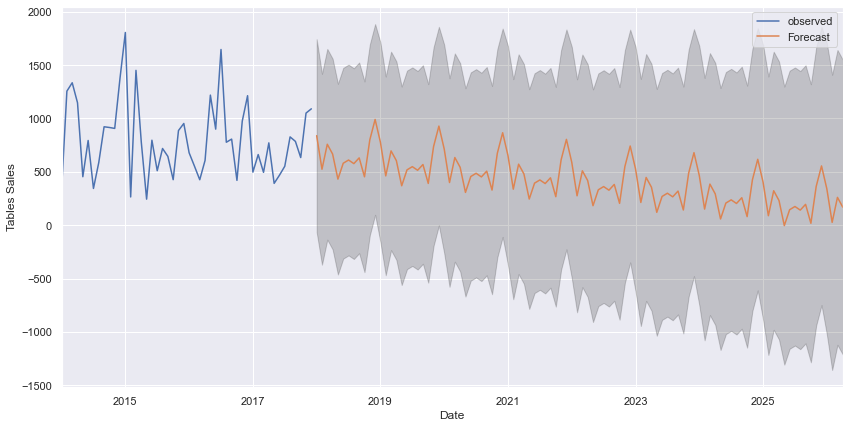

In [109]:
pred_uc = results_tables.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()

ax = monthly_tables.plot(label = 'observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax = ax, label ='Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],
               color = 'k',
               alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('Tables Sales')
plt.legend()
plt.show()

In [110]:
Furnishings = dataset.loc[dataset['Sub-Category'] == 'Furnishings']
Chairs = dataset.loc[dataset['Sub-Category'] == 'Chairs']
Tables = dataset.loc[dataset['Sub-Category'] == 'Tables']
Bookcases = dataset.loc[dataset['Sub-Category'] == 'Bookcases']
Furnishings.shape, Chairs.shape,Tables.shape,Bookcases.shape

((957, 21), (617, 21), (319, 21), (228, 21))

In [111]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 
        'State','Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 
        'Discount', 'Profit']
Furnishings.drop(cols, axis=1, inplace=True)
Chairs.drop(cols, axis=1, inplace=True)

Furnishings = Furnishings.sort_values('Order Date')
Chairs = Chairs.sort_values('Order Date')

Furnishings = Furnishings.groupby('Order Date')['Sales'].sum().reset_index()
Chairs = Chairs.groupby('Order Date')['Sales'].sum().reset_index()

Furnishings = Furnishings.set_index('Order Date')
Chairs = Chairs.set_index('Order Date')

y_Furnishings = Furnishings['Sales'].resample('MS').mean()
y_Chairs= Chairs['Sales'].resample('MS').mean()

Furnishings = pd.DataFrame({'Order Date':y_Furnishings.index, 'Sales':y_Furnishings.values})
Chairs = pd.DataFrame({'Order Date': y_Chairs.index, 'Sales': y_Chairs.values})
Chairs = pd.DataFrame({'Order Date': y_Chairs.index, 'Sales': y_Chairs.values})
Chairs = pd.DataFrame({'Order Date': y_Chairs.index, 'Sales': y_Chairs.values})

In [112]:
Furnishings1 = pd.DataFrame({'Order Date':monthly_fur.index, 'Sales':monthly_fur.values})
Chairs1 = pd.DataFrame({'Order Date': monthly_chairs.index, 'Sales': monthly_chairs.values})
Tables1 = pd.DataFrame({'Order Date': monthly_tables.index, 'Sales': monthly_tables.values})
Bookcases1 = pd.DataFrame({'Order Date': monthly_book.index, 'Sales': monthly_book.values})

In [113]:
store = Furnishings1.merge(Chairs1, on='Order Date', how='inner')
store.rename(columns={'Sales_x': 'Furnishings Sales', 'Sales_y': 'Chairs Sales'}, inplace=True)
store.head()

,Order Date,Furnishings Sales,Chairs Sales
0,2014-01-01,101.681429,1395.900000
1,2014-02-01,98.245000,95.229000
2,2014-03-01,68.589714,714.142750
3,2014-04-01,98.404600,642.133200
4,2014-05-01,111.452286,459.388625


In [114]:
store1 = Tables1.merge(Bookcases1, on='Order Date', how='inner')
store1.rename(columns={'Sales_x': 'Tables Sales', 'Sales_y': 'Bookcases Sales'}, inplace=True)
store1.head()

,Order Date,Tables Sales,Bookcases Sales
0,2014-01-01,333.000000,202.011000
1,2014-02-01,1256.220000,501.074300
2,2014-03-01,1334.848000,568.815333
3,2014-04-01,1147.208667,308.499000
4,2014-05-01,454.220250,320.315500


### comparing sales of all sub-category

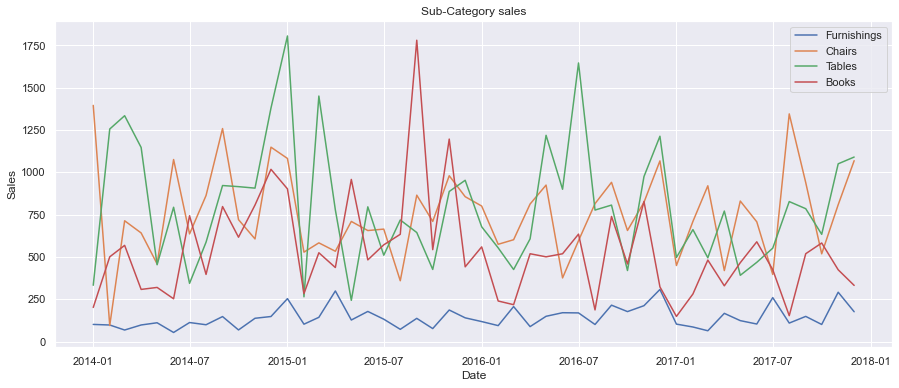

In [115]:
plt.figure(figsize=(15, 6))
plt.plot(store['Order Date'], store['Furnishings Sales'], label='Furnishings')
plt.plot(store['Order Date'], store['Chairs Sales'], label='Chairs')
plt.plot(store1['Order Date'], store1['Tables Sales'], label='Tables')
plt.plot(store1['Order Date'], store1['Bookcases Sales'], label='Books')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sub-Category sales')
plt.legend()

## Few Observations:
The above plot clearly shows that tables has maximum sales and furnishings perform worst in sales.

The sales are generally low at the beginning of every year as evident from decreasing line slope at the onset of year 2014, 2015, 2016  except Chairs.

Also, monthly average sales of furnishings is lower than that of Chairs,Tables,Books. It's probably because cost of furnishings is much more as compared to cost of other sub category.

But there are few instances in the time series where furnishings sales surpass books sales. It is mainly in July 2016 for the first time in the dataset.

### As we do it on sales same we can apply it on Profit to predict it